# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages, which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission if necessary. 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

In addition to implementing code, there is a writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) that can be used to guide the writing process. Completing the code template and writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/481/view) for this project.

The [rubric](https://review.udacity.com/#!/rubrics/481/view) contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this Ipython notebook and also discuss the results in the writeup file.


>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
import pickle
from sklearn.utils import shuffle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from tensorflow.contrib.layers import flatten
import os, sys
import matplotlib.image as mpimg
from PIL import Image
from itertools import compress
import random
import math
import cv2

In [2]:
# Load pickled data

training_file = 'data/train.p'
validation_file = 'data/valid.p'
testing_file = 'data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

In [3]:
# Resize the images inside 'images' directory
# This step should have been part of "Step 3", but
# I had a problem where values from session loaded from checkpoint
# was different from when the session was used directly to predict.
# Resetting the computer resolved this issue.

size = 32, 32
dirname = 'images'
try:
    os.mkdir(dirname+'/thumbs')
except:
    print(dirname+'/thumbs already exists, now creating images...')
for infile in os.listdir(dirname):
    if infile.endswith(".png"):
        outfile = dirname+'/thumbs/'+os.path.splitext(infile)[0] + "t.jpg"
        if infile != outfile:
            try:
                im = Image.open(dirname+'/'+infile)
                im.thumbnail(size, Image.ANTIALIAS)
                im.save(outfile, "JPEG")
                print('created: '+outfile)
            except IOError:
                print("cannot create thumbnail for '%s'" % infile)
                

dirname = 'images/thumbs'
sample_images = []
for img in os.listdir(dirname):
    image = mpimg.imread(dirname+'/'+img)
    sample_images.append(image)

answers = [4, 25, 14, 34, 3]
    
def display_predictions(images, answers, converter=None, height=32):
    signnames = pd.read_csv('signnames.csv')
    if converter is not None:
        images = converter(images)
    for i, answer in enumerate(answers):
        a = fig.add_subplot(1, 5, i+1)
        plt.imshow(images[i])
        plt.text(-1, height+8, signnames['SignName'][answer], va='top')

images/thumbs already exists, now creating images...
created: images/thumbs/0t.jpg
created: images/thumbs/1t.jpg
created: images/thumbs/2t.jpg
created: images/thumbs/3t.jpg
created: images/thumbs/4t.jpg


---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [57]:
n_train = len(X_train)
n_valid = len(X_valid)
n_test = len(X_test)
image_shape = X_train[0].shape
n_classes = len(np.unique(y_train))

print("Number of training examples =", n_train)
print("Number of validation examples =", n_valid)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

13


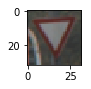

In [5]:
# Visualizations will be shown in the notebook.
%matplotlib inline

index = random.randint(0, len(X_train))
image = X_train[index].squeeze()

plt.figure(figsize=(1,1))
plt.imshow(image, cmap="gray")
print(y_train[index])

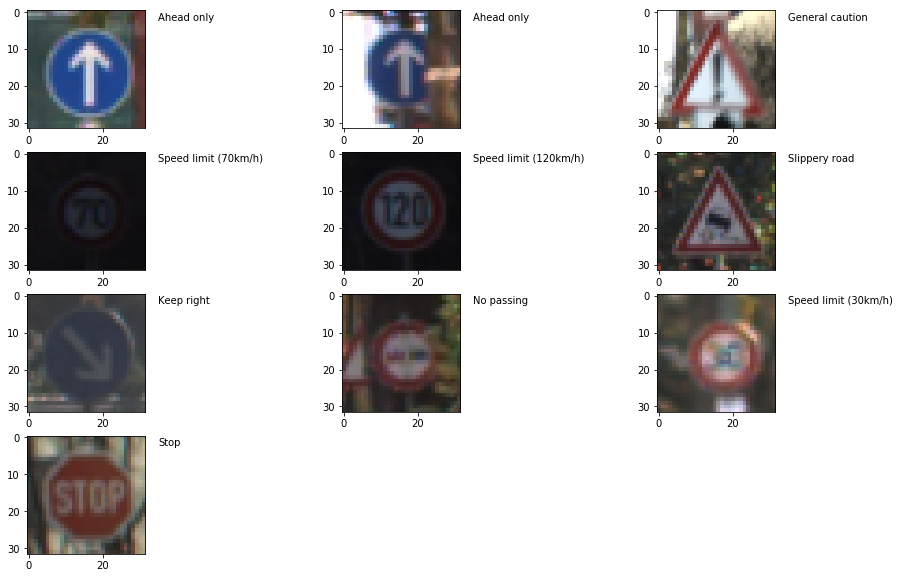

In [6]:
# Sanity check
sample_size = 10
X_sample, y_sample = shuffle(X_train,  y_train)
X_sample = X_sample[:sample_size]
y_sample = y_sample[:sample_size]
signnames = pd.read_csv('signnames.csv')
fig = plt.figure(figsize=(16, 10))

for i, (X, y) in enumerate(zip(X_sample, y_sample)):
    a = fig.add_subplot(math.ceil(float(sample_size)/3.), 3, i+1)
    plt.imshow(X)
    plt.text(35, 0, signnames['SignName'][y], va='top')

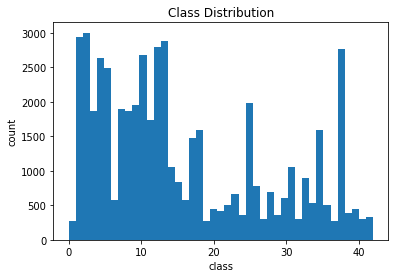

In [230]:
df = pd.DataFrame(data=np.hstack((y_train, y_valid, y_test))[:], columns=['class'])
n, bins, patches = plt.hist(df['class'], n_classes)
plt.xlabel('class')
plt.ylabel('count')
plt.title('Class Distribution')
_ = plt.show()

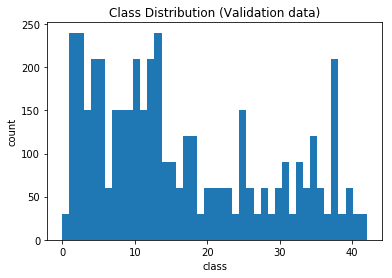

In [308]:
df = pd.DataFrame(data=np.hstack((y_valid))[:], columns=['class'])
n, bins, patches = plt.hist(df['class'], n_classes)
plt.xlabel('class')
plt.ylabel('count')
plt.title('Class Distribution (Validation data)')
_ = plt.show()

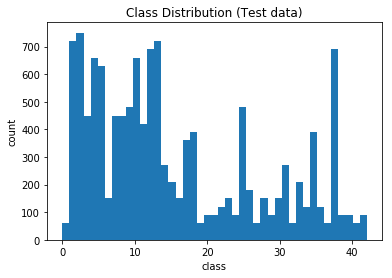

In [309]:
df = pd.DataFrame(data=np.hstack((y_test))[:], columns=['class'])
n, bins, patches = plt.hist(df['class'], n_classes)
plt.xlabel('class')
plt.ylabel('count')
plt.title('Class Distribution (Test data)')
_ = plt.show()

In [229]:
signnames = pd.read_csv('signnames.csv')
sorted_series = df.groupby(['class'])['class'].count().sort_values(ascending=False)[:10]
idx = []
signs = []
counts = []
for i in sorted_series.index:
    idx.append(i)
    signs.append(signnames['SignName'][i])
    counts.append(sorted_series[i])
pd.DataFrame(list(zip(idx, signs,counts)), columns=['ID', 'Sign Name', 'Count'])

,ID,Sign Name,Count
0,2,Speed limit (50km/h),3000
1,1,Speed limit (30km/h),2940
2,13,Yield,2880
3,12,Priority road,2790
4,38,Keep right,2760
5,10,No passing for vehicles over 3.5 metric tons,2670
6,4,Speed limit (70km/h),2640
7,5,Speed limit (80km/h),2490
8,25,Road work,1980
9,9,No passing,1950


----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play! 

With the LeNet-5 solution from the lecture, you should expect a validation set accuracy of about 0.89. To meet specifications, the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission. 

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Pre-process the Data Set (normalization, grayscale, etc.)

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.

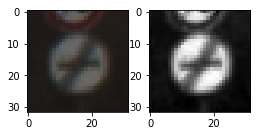

In [242]:
tf.reset_default_graph() 

X_train, y_train = shuffle(X_train, y_train)
X_valid, y_valid = shuffle(X_valid, y_valid)
X_test, y_test = shuffle(X_test, y_test)

def grayscale(image):
    logits = tf.image.rgb_to_grayscale(image)
    return logits

def normalize(image, min_val, max_val, min_color=0, max_color=255):
    """ Normalize image colors between min and max values
    
    a + ( ( (image_data - grayscale_min)*(b - a) )/( grayscale_max - grayscale_min ) )
    """
    output = tf.divide(
        tf.multiply(tf.subtract(image, min_color), tf.subtract(max_val, min_val)),
        (max_color - min_color)
    )
    return output
    
def preprocess(inputs):
    logits = grayscale(inputs)
    logits = normalize(logits, 0.1, 0.9)
    return logits

X = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)
preprocess_test = preprocess(X)

## Testing preprocess step
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    X_few, y_few = X_train[:1], y_train[:1]
    results = sess.run(preprocess_test, feed_dict={X: X_few, y: y_few})
image = results[0,:,:,0]
fig = plt.figure(figsize=(4, 4))
a = fig.add_subplot(1, 2, 1)
plt.imshow(X_train[0])
a = fig.add_subplot(1, 2, 2)
plt.imshow(image, cmap="gray")

### Model Architecture

We are going to compare LeNet with another model(s?).

In [8]:
def LeNet(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal((5, 5, 1, 6), mean = mu, stddev = sigma), name='conv1_W')
    conv1_b = tf.Variable(tf.zeros((6)), name='conv1_b')
    strides = [1, 1, 1, 1]
    conv1 = tf.nn.conv2d(x, conv1_W, strides=strides, padding='VALID', name='conv1') + conv1_b
    
    # Activation.
    conv1 = tf.nn.relu(conv1, name='conv1_actd')

    # Pooling. Input = 28x28x6. Output = 14x14x6.
    strides = [1, 2, 2, 1]
    conv1 = tf.nn.max_pool(conv1, ksize=strides, strides=strides, padding='VALID', name='pool1')

    # Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal((5, 5, 6, 16), mean = mu, stddev = sigma), name='conv2_W')
    conv2_b = tf.Variable(tf.zeros((16)), name='conv2_b')
    strides = [1, 1, 1, 1]
    conv2 = tf.nn.conv2d(conv1, conv2_W, strides=strides, padding='VALID', name='conv2') + conv2_b
    
    # Activation.
    conv2 = tf.nn.relu(conv2, name='conv2_actd')

    # Pooling. Input = 10x10x16. Output = 5x5x16.
    strides = [1, 2, 2, 1]
    conv2 = tf.nn.max_pool(conv2, ksize=strides, strides=strides, padding='VALID', name='pool2')

    # Flatten. Input = 5x5x16. Output = 400.
    flat1 = tf.contrib.layers.flatten(conv2)
    
    # Layer 3: Fully Connected. Input = 400. Output = 120.
    flat2_W = tf.Variable(tf.truncated_normal((400, 120), mean = mu, stddev = sigma), name='flat2_W')
    flat2_b = tf.Variable(tf.zeros((120)), name='flat2_b')
    flat2 = tf.add(tf.matmul(flat1, flat2_W), flat2_b, name='flat2')
    
    # Activation.
    flat2 = tf.nn.relu(flat2, name='flat2_actd')

    # Layer 4: Fully Connected. Input = 120. Output = 84.
    flat3_W = tf.Variable(tf.truncated_normal((120, 84), mean = mu, stddev = sigma), name='flat3_W')
    flat3_b = tf.Variable(tf.zeros((84)), name='flat3_b')
    flat3 = tf.add(tf.matmul(flat2, flat3_W), flat3_b, name='flat3')
    
    # Activation.
    flat3 = tf.nn.relu(flat3, name='flat3_actd')

    # Layer 5: Fully Connected. Input = 84. Output = n_classes.
    flat4_W = tf.Variable(tf.truncated_normal((84, n_classes), mean = mu, stddev = sigma), name='flat4_W')
    flat4_b = tf.Variable(tf.zeros((n_classes)), name='flat4_b')
    flat4 = tf.add(tf.matmul(flat3, flat4_W), flat4_b, name='output')
   
    logits = flat4
    return logits

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

Training...

EPOCH 1 ...
Validation Accuracy = 0.668

EPOCH 2 ...
Validation Accuracy = 0.817

EPOCH 3 ...
Validation Accuracy = 0.848

EPOCH 4 ...
Validation Accuracy = 0.867

EPOCH 5 ...
Validation Accuracy = 0.872

EPOCH 6 ...
Validation Accuracy = 0.897

EPOCH 7 ...
Validation Accuracy = 0.907

EPOCH 8 ...
Validation Accuracy = 0.903

EPOCH 9 ...
Validation Accuracy = 0.900

EPOCH 10 ...
Validation Accuracy = 0.919

Model saved
Wall time: 20.1 s


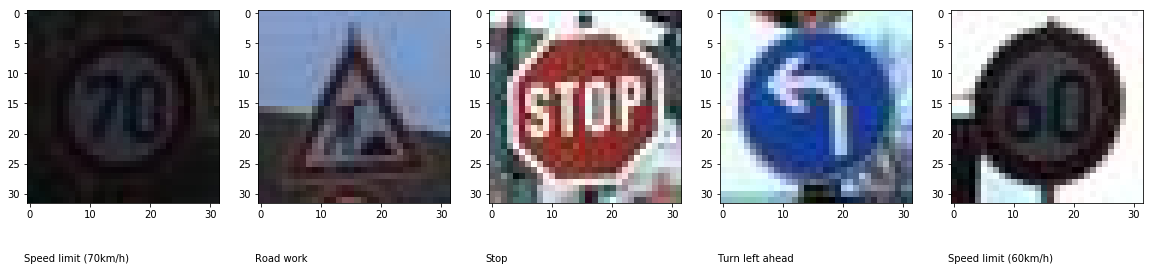

In [287]:
%%time
tf.reset_default_graph()
EPOCHS = 10
BATCH_SIZE = 128

rate = 0.001

X = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)
logits = preprocess(X)
logits = LeNet(logits)

cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=one_hot_y, name='xent')
loss_operation = tf.reduce_mean(cross_entropy, name='loss')
optimizer = tf.train.AdamOptimizer(learning_rate = rate, name='opt')
training_operation = optimizer.minimize(loss_operation)

def evaluate(X_data, y_data, one_hot_y, logits):
    correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
    accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={X: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

saver = tf.train.Saver()

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={X: batch_x, y: batch_y})
            
        validation_accuracy = evaluate(X_valid, y_valid, one_hot_y, logits)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, './lenet.ckpt')
    print("Model saved")
    
    # Making sure the model can be used to predict new images.
    # This step was added since there was a problem (small Tensorflow bug?) with
    # saving and loading checkpoint where somehow `session.run` returned
    # different results than using the original logits (i.e. not loaded from checkpoint).
    # Resetting the computer resolved this issue. Weird.
    y_label = tf.argmax(logits, 1, name='output_label')
    machine_answers = sess.run(y_label, feed_dict={X: sample_images, y: np.zeros(len(sample_images))})
    fig = plt.figure(figsize=(20, 10))
    display_predictions(sample_images, machine_answers)


---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

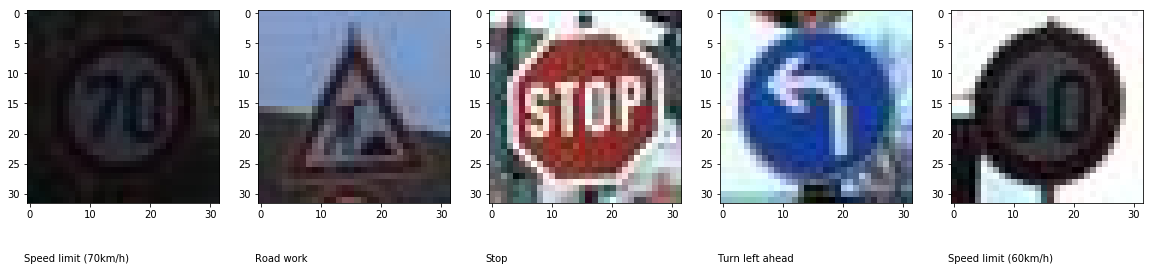

In [10]:
dirname = 'images/thumbs'
fig = plt.figure(figsize=(20, 10))
images = []
for img in os.listdir(dirname):
    image = mpimg.imread(dirname+'/'+img)
    images.append(image)

answers = [4, 25, 14, 34, 3]
display_predictions(images, answers)

### Predict the Sign Type for Each Image

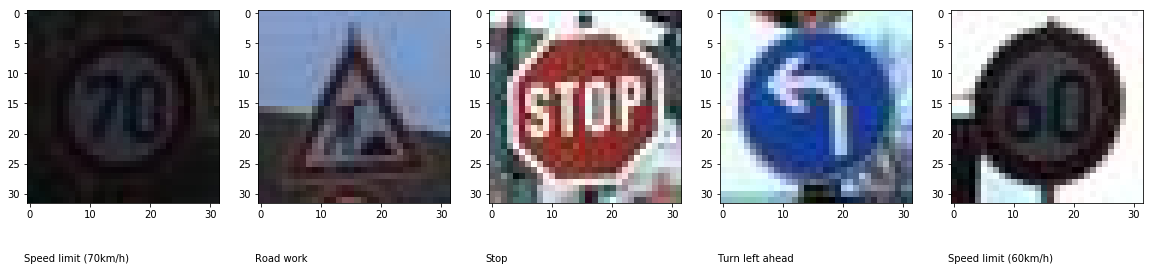

In [296]:
# This is needed so we can try creating a graph from scratch and load the variables.
tf.reset_default_graph() 

X = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)
logits = preprocess(X)
logits = LeNet(logits)
y_label = tf.argmax(logits, 1, name='output_label')
y_data = np.zeros(len(images))

saver = tf.train.Saver() 

with tf.Session() as sess:
    saver.restore(sess, './lenet.ckpt')
    machine_answers = sess.run(logits, feed_dict={X: images, y: y_data})

machine_answers_label = np.argmax(machine_answers, axis=1)
fig = plt.figure(figsize=(20, 10))
display_predictions(images, machine_answers_label)

### Analyze Performance

In [297]:
tf.reset_default_graph() 

X = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)
logits = preprocess(X)
logits = LeNet(logits)
saver = tf.train.Saver() 

with tf.Session() as sess:
    saver.restore(sess, './lenet.ckpt')
    test_accuracy = evaluate(images, answers, one_hot_y, logits)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 1.000


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tk.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

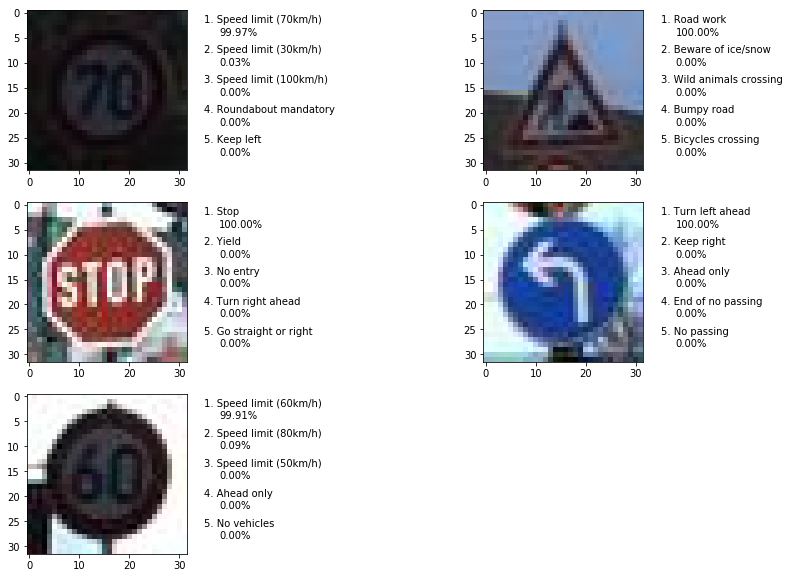

In [298]:
tf.reset_default_graph() 
with tf.Session() as sess:
    top5 = sess.run(tf.nn.top_k(tf.nn.softmax(tf.constant(machine_answers)), k=5))
    signnames = pd.read_csv('signnames.csv')
    fig = plt.figure(figsize=(15, 10))
    for i, indices in enumerate(top5.indices):
        a = fig.add_subplot(3, 2, i+1)
        plt.imshow(images[i])
        for j, index in enumerate(indices):
            plt.text(35, (j*6)+2, "{}. {}".format(j+1, signnames['SignName'][index]))
            plt.text(38, (j*6)+4.5, "{:.2%}".format(top5.values[i][j]))

---

## Step 4: Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [52]:
# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during training procedure that represents the calculated state of 
#                a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min 
#                     and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt 
#          number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way the network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it maybe having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={X : image_input})
    featuremaps = activation.shape[3]
    figsize_x = 15
    figsize_y = 15
    subplot_y = 6
    subplot_x = 8
    small = False
    if featuremaps > (subplot_x * subplot_y):
        small = True
        subplot_x = 15
        subplot_y = math.ceil(float(featuremaps) / float(subplot_x))
        figsize_y = subplot_y
    plt.figure(plt_num, figsize=(figsize_x, figsize_y))
    for featuremap in range(featuremaps):
        plt.subplot(subplot_y, subplot_x, featuremap+1) # sets the number of feature maps to show on each row and column
        if not small:
            plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")
            
def evaluate_prediction(X_data, y_data, logits, one_hot_y, logit_name='output:0'):
    incorrect_bool = tf.not_equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
    i_images = []
    i_predictions = []
    i_labels = []
    c_images = []
    c_labels = []
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        incorrect = sess.run(incorrect_bool, feed_dict={X: batch_x, y: batch_y})
        outputs = np.argmax(tf.get_default_graph().get_tensor_by_name(logit_name).eval(
            session=sess,feed_dict={X: batch_x}), axis=1)
        # compressed incorrect variables
        c_i_images = compress(batch_x, incorrect)
        c_i_outputs = compress(outputs, incorrect)
        c_i_labels = compress(batch_y, incorrect)
        for i, (image, prediction, label) in enumerate(zip(c_i_images, c_i_outputs, c_i_labels)):
            i_images.append(image)
            i_predictions.append(prediction)
            i_labels.append(label)
        
        # compressed correct variables
        c_c_images = compress(batch_x, [not i for i in incorrect])
        c_c_labels = compress(batch_y, [not i for i in incorrect])
        for i, (image, label) in enumerate(zip(c_c_images, c_c_labels)):
            c_images.append(image)
            c_labels.append(label)
# Sanity check
#     print(incorrect)
#     print(batch_y)
#     for i, (_x, _y) in enumerate(zip(compress(batch_x, incorrect), compress(batch_y, incorrect))):
#         print(_y)
#         print(signnames['SignName'][_y])
#         a = fig.add_subplot(math.ceil(float(sample_size)/3.), 3, i+1)
#         plt.imshow(_x)

    return((i_images, i_predictions, i_labels), (c_images, c_labels))

We will first examine the error examples:

Total incorrect guesses: 410


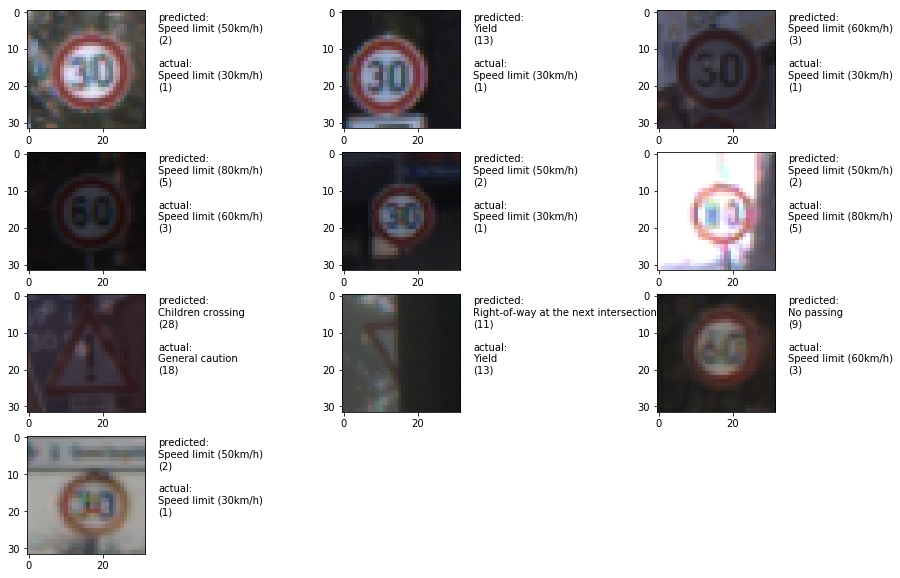

In [302]:
sample_size = 10

tf.reset_default_graph()

X = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)
logits = preprocess(X)
logits = LeNet(logits)
fig = plt.figure(figsize=(16, 10))

saver = tf.train.Saver()
sess = tf.Session()
saver.restore(sess, './lenet.ckpt')

(i_images, i_predictions, i_labels), (c_images, c_labels) = evaluate_prediction(X_train, y_train, logits, one_hot_y)
print("Total incorrect guesses: {}".format(len(i_predictions)))
# print("Random {} incorrect guesses".format(sample_size))
# i_images, i_predictions, i_labels = shuffle(i_images, i_predictions, i_labels)
signnames = pd.read_csv('signnames.csv')
for i, (image, prediction, label) in enumerate(
    zip(i_images[:sample_size], i_predictions[:sample_size], i_labels[:sample_size])):
    a = fig.add_subplot(math.ceil(float(sample_size)/3.), 3, i+1)
    plt.imshow(image)
    plt.text(35, 0, "predicted:\n{}\n({})\n\nactual:\n{}\n({})".format(
        signnames['SignName'][prediction],
        prediction,
        signnames['SignName'][label],
        label
    ), va='top')


### Conv 1

In this section, we compare the result of first convolutional layer of incorrect and correct image to get an insight on what can be improved.

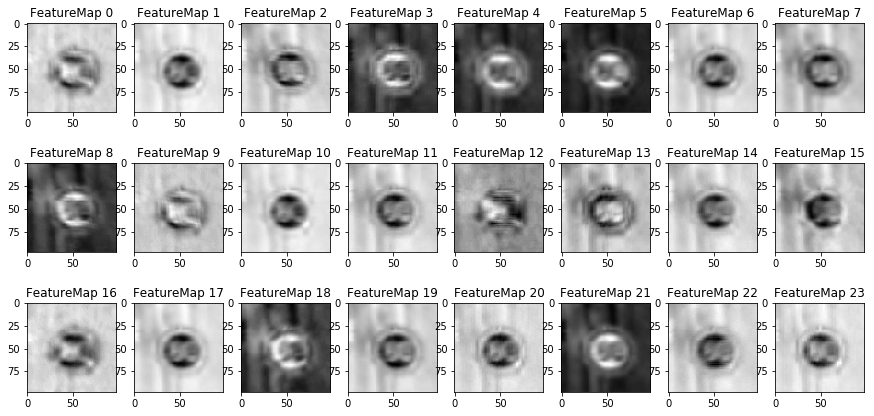

In [301]:
# Incorrect image
outputFeatureMap([i_images[9]], tf.get_default_graph().get_tensor_by_name("conv1:0"))

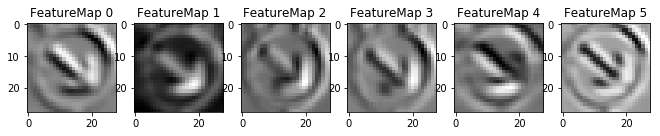

In [303]:
# Correct image
outputFeatureMap([c_images[3]], tf.get_default_graph().get_tensor_by_name("conv1:0"))

### Conv 2

Let's also see the result of second convolutional layer:

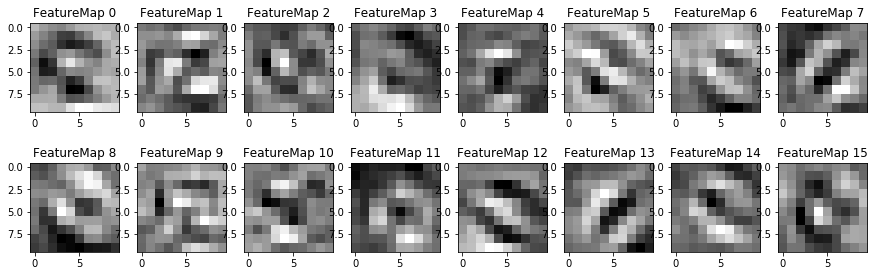

In [304]:
# Incorrect image
outputFeatureMap([i_images[0]], tf.get_default_graph().get_tensor_by_name("conv2:0"))

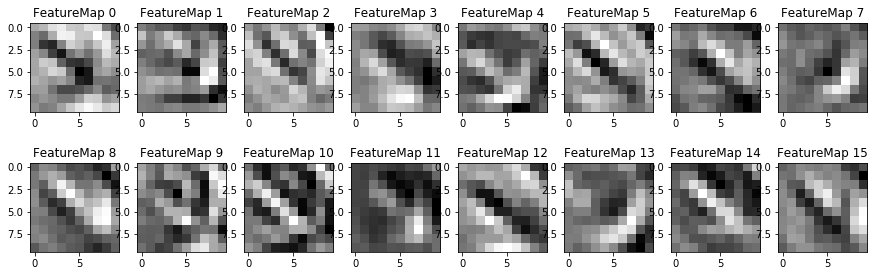

In [305]:
# Correct image
outputFeatureMap([c_images[3]], tf.get_default_graph().get_tensor_by_name("conv2:0"))

### Question 9

Discuss how you used the visual output of your trained network's feature maps to show that it had learned to look for interesting characteristics in traffic sign images


**Answer:**

From the above visualizations, the features for second convolutional layer of incorrect and correct predictions were considered to be the same. I am not sure if human eyes can differentiate distinct characteristics of these feature maps; My eyes, for certain, cannot do so.

There is an interesting characteristics to be found here, however, and that is the fact that the first convolutional layer was able to detect the lines in the image.

---
## Update the convolutional network

We have so far been succesfull in creating, testing, and visualizing our convolutional network, but it does not currently meet the required 93% accuracy just yet.

Below, we update the convolutional network to use [NVIDIA's ConvNet](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) and see if that improves the network's performance. It looks like this network does not greyscale the image, which kind of make sense since colors do have importance in reading traffic signs (e.g. red and yellow triangles mean different things).

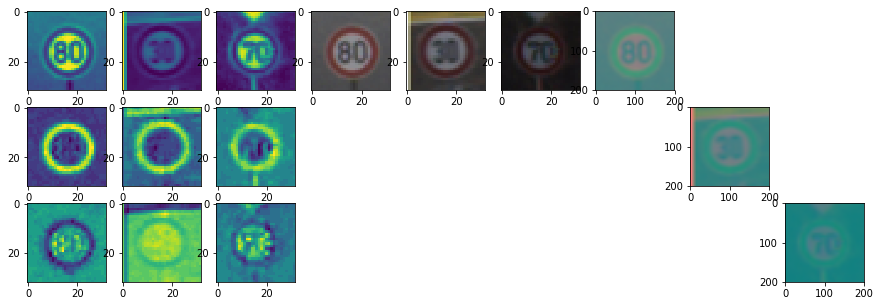

In [280]:
# Testing YUV color space
def rgb2yuv(X):
    X = np.asarray(X)
    new_images = np.zeros(X.shape, np.uint8)    
    for i, x in enumerate(X):
        new_images[i] = cv2.cvtColor(x, cv2.COLOR_RGB2YCrCb)
    return new_images

def yuv2rgb(X):
    X = np.asarray(X)
    new_images = np.zeros(X.shape, np.uint8)    
    for i, x in enumerate(X):
        new_images[i] = cv2.cvtColor(x, cv2.COLOR_YCrCb2RGB)
    return new_images
    
def resize(X, x, y):
    X = np.asarray(X)
    new_images = np.zeros((len(X), x, y, 3), np.uint8)
    for i, image in enumerate(X):
        new_images[i] = cv2.resize(image, (x, y))
    return new_images

def preprocess2(X, y=[]):
    return resize(rgb2yuv(X.copy()), 200, 200), y.copy()

fig = plt.figure(figsize=(15, 5))
imgs = rgb2yuv(shuffle(X_train)[:3])
for i in range(0,3):
    a = fig.add_subplot(3, 9, (0*9)+i+1)
    plt.imshow(imgs[i,:,:,0])
    a = fig.add_subplot(3, 9, (1*9)+i+1)
    plt.imshow(imgs[i,:,:,1])
    a = fig.add_subplot(3, 9, (2*9)+i+1)
    plt.imshow(imgs[i,:,:,2])

counter = i+1
imgs = yuv2rgb(imgs)
for i in range(0,3):
    a = fig.add_subplot(3, 9, i+counter+1)
    plt.imshow(imgs[i])

counter += i+1
imgs, _ = preprocess2(imgs)
for i in range(0,3):
    a = fig.add_subplot(3, 9, (i*9)+i+counter+1)
    plt.imshow(imgs[i])


In [21]:
def NVIDIANet(X):
    mu = 0
    sigma = 0.1
    
    ## Preprocess: Normalize, but don't convert to grayscale
    normalized = normalize(X, 0., 1., min_color=16, max_color=265)
    
    # Layer 1: Convolutional. Input = 200x200x3. Output = 98x98x24.
    conv1_W = tf.Variable(tf.truncated_normal((5, 5, 3, 24), mean = mu, stddev = sigma), name='conv1_W')
    conv1_b = tf.Variable(tf.zeros((24)), name='conv1_b')
    strides = [1, 2, 2, 1]
    conv1 = tf.nn.conv2d(normalized, conv1_W, strides=strides, padding='VALID', name='conv1') + conv1_b
    # Activation.
    conv1 = tf.nn.relu(conv1, name='conv1_actd')

    # Layer 2: Convolutional. Input = 98x98x24. Output = 47x47x36.
    conv2_W = tf.Variable(tf.truncated_normal((5, 5, 24, 36), mean = mu, stddev = sigma), name='conv2_W')
    conv2_b = tf.Variable(tf.zeros((36)), name='conv2_b')
    strides = [1, 2, 2, 1]
    conv2 = tf.nn.conv2d(conv1, conv2_W, strides=strides, padding='VALID', name='conv2') + conv2_b
    # Activation.
    conv2 = tf.nn.relu(conv2, name='conv2_actd')

    # Layer 3: Convolutional. Input = 47x47x36. Output = 22x22x48.
    conv3_W = tf.Variable(tf.truncated_normal((5, 5, 36, 48), mean = mu, stddev = sigma), name='conv3_W')
    conv3_b = tf.Variable(tf.zeros((48)), name='conv3_b')
    strides = [1, 2, 2, 1]
    conv3 = tf.nn.conv2d(conv2, conv3_W, strides=strides, padding='VALID', name='conv3') + conv3_b
    # Activation.
    conv3 = tf.nn.relu(conv3, name='conv3_actd')

    # Layer 4: Convolutional. Input = 22x22x48. Output = 20x20x64.
    conv4_W = tf.Variable(tf.truncated_normal((3, 3, 48, 64), mean = mu, stddev = sigma), name='conv4_W')
    conv4_b = tf.Variable(tf.zeros((64)), name='conv4_b')
    strides = [1, 1, 1, 1]
    conv4 = tf.nn.conv2d(conv3, conv4_W, strides=strides, padding='VALID', name='conv4') + conv4_b
    # Activation.
    conv4 = tf.nn.relu(conv4, name='conv4_actd')
    
    # Layer 5: Convolutional. Input = 20x20x64. Output = 18x18x64.
    conv5_W = tf.Variable(tf.truncated_normal((3, 3, 64, 64), mean = mu, stddev = sigma), name='conv5_W')
    conv5_b = tf.Variable(tf.zeros((64)), name='conv4_b')
    strides = [1, 1, 1, 1]
    conv5 = tf.nn.conv2d(conv4, conv5_W, strides=strides, padding='VALID', name='conv5') + conv5_b
    # Activation.
    conv5 = tf.nn.relu(conv5, name='conv5_actd')

    # Flatten. Output = 20736 (18x18x64)
    flat = tf.contrib.layers.flatten(conv5)
    
    # Layer 6: Fully Connected. Input = 20736. Output = 100.
    conn1_W = tf.Variable(tf.truncated_normal((20736, 100), mean = mu, stddev = sigma), name='conn1_W')
    conn1_b = tf.Variable(tf.zeros((100)), name='conn1_b')
    conn1 = tf.add(tf.matmul(flat, conn1_W), conn1_b, name='conn1')

    # Layer 7: Fully Connected. Input = 100. Output = 43.
    conn2_W = tf.Variable(tf.truncated_normal((100, 43), mean = mu, stddev = sigma), name='conn2_W')
    conn2_b = tf.Variable(tf.zeros((43)), name='conn2_b')
    conn2 = tf.add(tf.matmul(conn1, conn2_W), conn2_b, name='conn2')

    logits = conn2
    return logits

### Train, Validate and Test the Model

Training...

EPOCH 1 ...
Validation Accuracy = 0.876

EPOCH 2 ...
Validation Accuracy = 0.885

EPOCH 3 ...
Validation Accuracy = 0.907

EPOCH 4 ...
Validation Accuracy = 0.924

EPOCH 5 ...
Validation Accuracy = 0.931

EPOCH 6 ...
Validation Accuracy = 0.929

EPOCH 7 ...
Validation Accuracy = 0.907

EPOCH 8 ...
Validation Accuracy = 0.937

EPOCH 9 ...
Validation Accuracy = 0.936

EPOCH 10 ...
Validation Accuracy = 0.941

Model saved
Wall time: 9min 27s


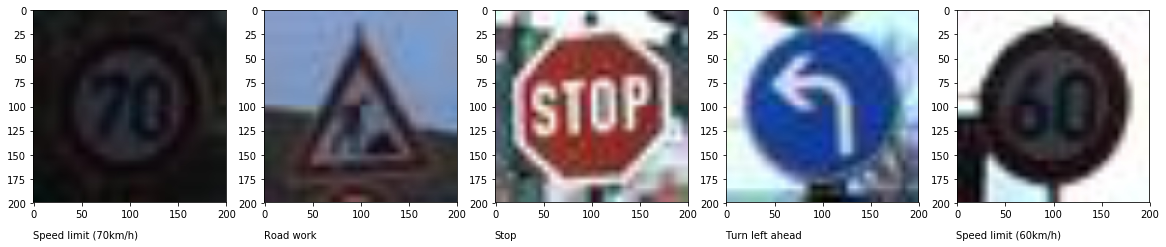

In [22]:
%%time

tf.reset_default_graph()

X_train1, y_train1 = preprocess2(X_train, y_train)
X_valid1, y_valid1 = preprocess2(X_valid, y_valid)
X_test1, y_test1 = preprocess2(X_test, y_test)
sample_images1, _ = preprocess2(sample_images)

EPOCHS = 10
BATCH_SIZE = 128

rate = 0.001

X = tf.placeholder(tf.float32, (None, 200, 200, 3))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)
logits = NVIDIANet(X)

cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=one_hot_y, name='xent')
loss_operation = tf.reduce_mean(cross_entropy, name='loss')
optimizer = tf.train.AdamOptimizer(learning_rate = rate, name='opt')
training_operation = optimizer.minimize(loss_operation)

def evaluate(X_data, y_data, one_hot_y, logits):
    correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
    accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={X: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

saver = tf.train.Saver()

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train1)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train1, y_train1 = shuffle(X_train1, y_train1)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train1[offset:end], y_train1[offset:end]
            sess.run(training_operation, feed_dict={X: batch_x, y: batch_y})
            
        validation_accuracy = evaluate(X_valid1, y_valid1, one_hot_y, logits)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, './nvidianet.ckpt')
    print("Model saved")
    
    # See how the model performs on five unique images.
    y_label = tf.argmax(logits, 1, name='output_label')
    machine_answers = sess.run(y_label, feed_dict={X: sample_images1, y: np.zeros(len(sample_images1))})
    fig = plt.figure(figsize=(20, 10))
    display_predictions(sample_images1, machine_answers, converter=yuv2rgb, height=220)


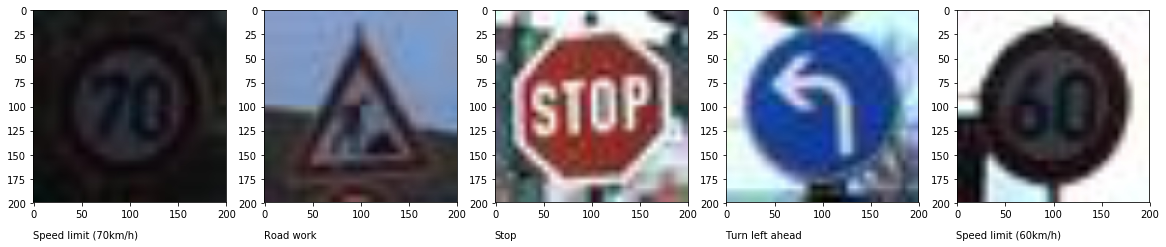

In [294]:
# This is needed so we can try creating a graph from scratch and load the variables.
tf.reset_default_graph() 

sample_images1, _ = preprocess2(sample_images)

X = tf.placeholder(tf.float32, (None, 200, 200, 3))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)
logits = NVIDIANet(X)
y_label = tf.argmax(logits, 1, name='output_label')
y_data = np.zeros(len(sample_images1))

saver = tf.train.Saver() 

with tf.Session() as sess:
    saver.restore(sess, './nvidianet.ckpt')
    machine_answers = sess.run(logits, feed_dict={X: sample_images1})

machine_answers_label = np.argmax(machine_answers, axis=1)
fig = plt.figure(figsize=(20, 10))
display_predictions(sample_images1, machine_answers_label, height=220, converter=yuv2rgb)

### Softmax Probabilities for 5 Images from the Web

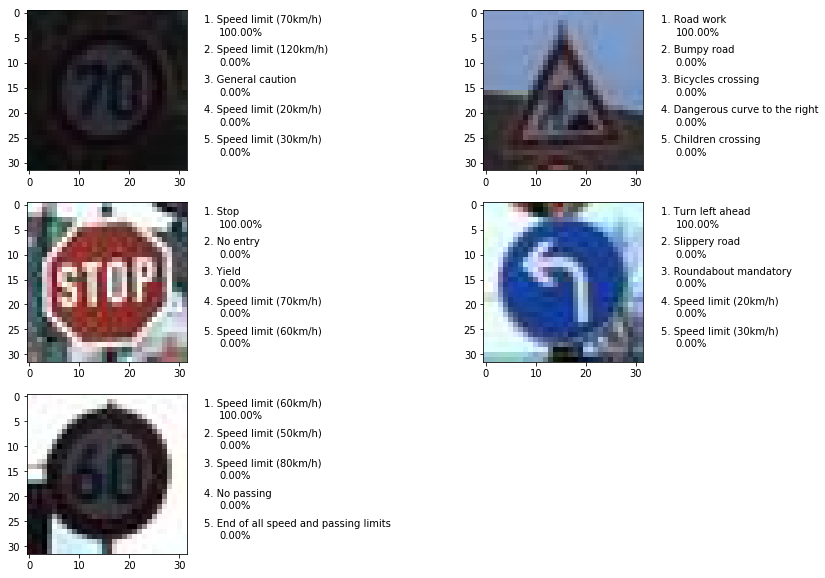

In [295]:
tf.reset_default_graph() 
with tf.Session() as sess:
    top5 = sess.run(tf.nn.top_k(tf.nn.softmax(tf.constant(machine_answers)), k=5))
    signnames = pd.read_csv('signnames.csv')
    fig = plt.figure(figsize=(15, 10))
    for i, indices in enumerate(top5.indices):
        a = fig.add_subplot(3, 2, i+1)
        plt.imshow(images[i])
        for j, index in enumerate(indices):
            plt.text(35, (j*6)+2, "{}. {}".format(j+1, signnames['SignName'][index]))
            plt.text(38, (j*6)+4.5, "{:.2%}".format(top5.values[i][j]))

### Investigating incorrectly predicted training images

Total incorrect guesses: 69
Training Accuracy: 0.9980171844018506


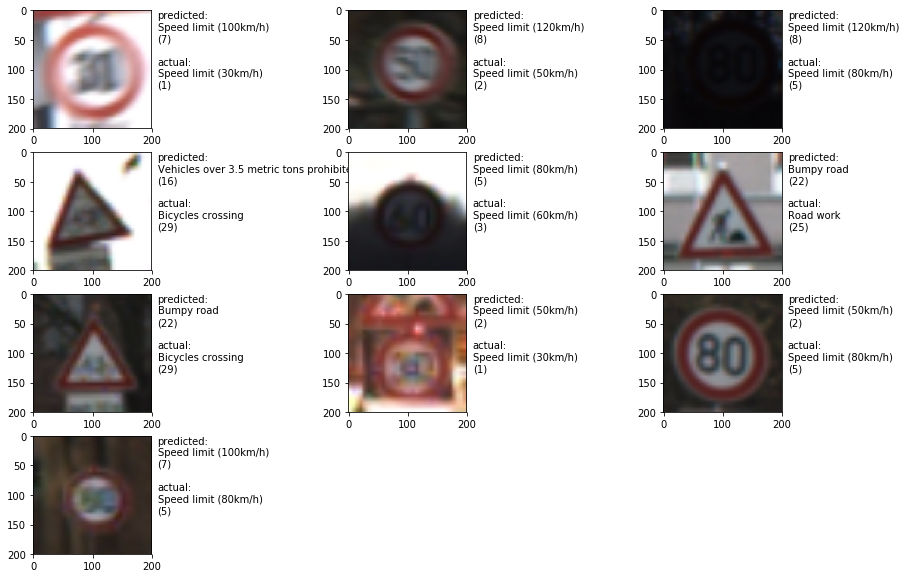

In [300]:
sample_size = 10

tf.reset_default_graph()

X = tf.placeholder(tf.float32, (None, 200, 200, 3))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)
logits = NVIDIANet(X)
fig = plt.figure(figsize=(16, 10))

saver = tf.train.Saver()
sess = tf.Session()
saver.restore(sess, './nvidianet.ckpt')

(i_images, i_predictions, i_labels), (c_images, c_labels) = evaluate_prediction(X_train1, y_train1, logits, one_hot_y, logit_name='conn2:0')
print("Total incorrect guesses: {}".format(len(i_predictions)))
print("Training Accuracy: {}".format(len(c_images)/(len(c_images) + len(i_images))))
# print("Random {} incorrect guesses".format(sample_size))
# i_images, i_predictions, i_labels = shuffle(i_images, i_predictions, i_labels)
signnames = pd.read_csv('signnames.csv')
i_images = yuv2rgb(i_images)
c_images = yuv2rgb(c_images)

fig = plt.figure(figsize=(16, 10))
for i, (image, prediction, label) in enumerate(
    zip(i_images[:sample_size], i_predictions[:sample_size], i_labels[:sample_size])):
    a = fig.add_subplot(math.ceil(float(sample_size)/3.), 3, i+1)
    _ = plt.imshow(image)
    plt.text(210, 0, "predicted:\n{}\n({})\n\nactual:\n{}\n({})".format(
        signnames['SignName'][prediction],
        prediction,
        signnames['SignName'][label],
        label
    ), va='top')


And again, below we visualize convolutional layers of one (incorrect) sample. It is nice to see how the first two layers focus on the edges and followed by more subtle characteristics.

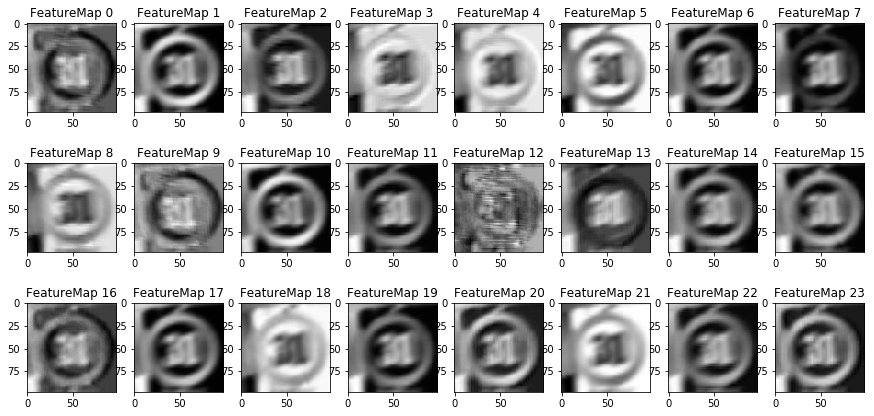

In [36]:
outputFeatureMap([i_images[0]], tf.get_default_graph().get_tensor_by_name("conv1:0"))

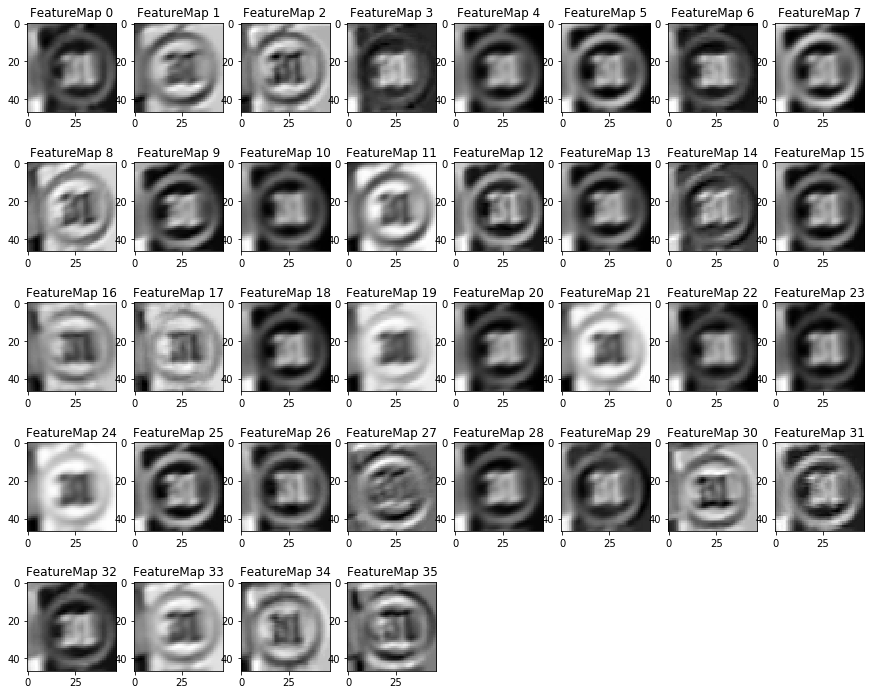

In [37]:
outputFeatureMap([i_images[0]], tf.get_default_graph().get_tensor_by_name("conv2:0"))

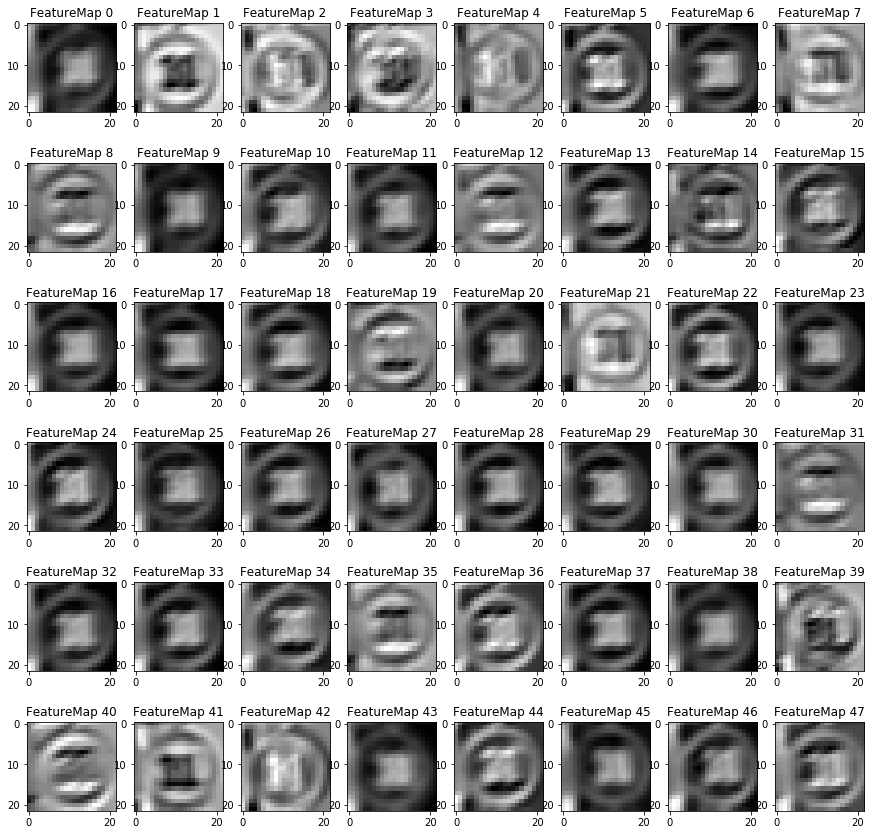

In [38]:
outputFeatureMap([i_images[0]], tf.get_default_graph().get_tensor_by_name("conv3:0"))

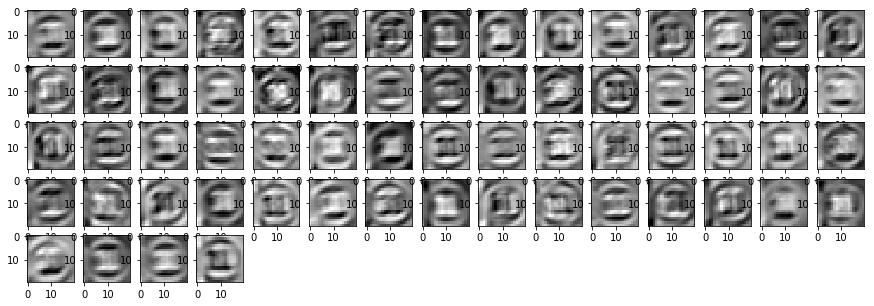

In [54]:
outputFeatureMap([i_images[0]], tf.get_default_graph().get_tensor_by_name("conv4:0"))

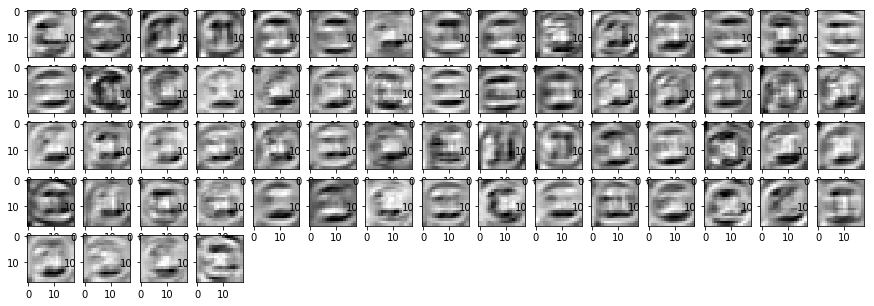

In [53]:
outputFeatureMap([i_images[0]], tf.get_default_graph().get_tensor_by_name("conv5:0"))

## Performance of the final model on the test set

In this section we measure the performance of the final model when used in the test set that we have never used above.

In [56]:
tf.reset_default_graph() 

X = tf.placeholder(tf.float32, (None, 200, 200, 3))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)
logits = NVIDIANet(X)
saver = tf.train.Saver() 

with tf.Session() as sess:
    saver.restore(sess, './nvidianet.ckpt')
    test_accuracy = evaluate(X_test1, y_test1, one_hot_y, logits)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.932


## Appendix 1. Sign names

In [77]:
signnames = pd.read_csv('signnames.csv')
signnames

,ClassId,SignName
0,0,Speed limit (20km/h)
1,1,Speed limit (30km/h)
2,2,Speed limit (50km/h)
3,3,Speed limit (60km/h)
4,4,Speed limit (70km/h)
5,5,Speed limit (80km/h)
6,6,End of speed limit (80km/h)
7,7,Speed limit (100km/h)
8,8,Speed limit (120km/h)
9,9,No passing
